In [2]:
from IPython.core.magic import register_cell_magic


@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

# **Import libraries and modules**

## Import libraries

In [3]:
import os
import sys
import pathlib
import shutil
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import modules

In [4]:
sys.path.insert(0, '../')

from generate_version import generate_version

# **Prepare the dataset for loading**

## Helper functions

In [5]:
def create_label_dir(df, dir='../gdsc-ai-challenge/train'):
    """Use Dataframe contains labels for each image and path to the directory

    contains the unlabeled dataset to rebuild directory into labeled subdirectories.

    Returns all the label and number of classes in the dataset.

    Keyword arguments:

    df -- The Dataframe contains images' names and labels.

    dir -- Path to the main directory (default to ../gdsc-ai-challenge/train)
    """
    class_names = np.sort(df['label'].unique())
    number_of_classes = len(class_names)

    if not os.path.exists(dir):
        return class_names, number_of_classes

    for class_name in class_names:
        subdir = pathlib.Path(os.path.join(dir, class_name))
        if subdir.exists():
            continue
        else:
            subdir.mkdir()
    
    return class_names, number_of_classes

def sort_data(df, dir='../gdsc-ai-challenge/train'):
    """Use Dataframe to move each unlabeled image to the correct label's subdirectory.

    df -- The Dataframe contains images' names and labels.

    dir -- Path to the main directory (default to ../gdsc-ai-challenge/train) 
    """
    if not os.path.exists(dir):
        return
    
    unlabeled_dir = os.path.join(dir, 'train')

    for image_dir in [str(img) for img in list(pathlib.Path(unlabeled_dir).glob('*.png'))]:
        id = int(image_dir.removeprefix(unlabeled_dir).removesuffix('.png'))
        label = df['label'][id - 1]
        dest_path = os.path.join(dir, label, str(id) + '.png')
        shutil.move(image_dir, dest_path)

## Prepare the dataset

In [6]:
label_df = pd.read_csv('../gdsc-ai-challenge/trainLabels.csv')

class_names, number_of_classes = create_label_dir(label_df)
sort_data(label_df)

# **Data preprocessing and augmentation**

## Helper functions

In [7]:
def split_dataset(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1):
    """Split the dataset into three subsets: train, validation (dev) and test set.

    Returns three tuples, containing each subset with its size.

    Keyword arguments:

    ds -- tf.data.Dataset object

    ds_size -- size of the dataset

    train_split -- percentage to split into train set (default to 0.8)

    val_split -- percentage to split into validation set (default to 0.1)

    test_split -- percentage to split into test set (default to 0.1)
    """
    assert (train_split + test_split + val_split) == 1
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return (train_ds, train_size), (val_ds, val_size), (test_ds, ds_size - val_size - train_size)

def configure(ds, ds_size, batch_size=32, shuffle=False, augment=False):
    """Configure the given dataset for better performance (by caching, prefetching and then batching the dataset)

    and perform preprocessing to the images in the given dataset.

    Returns the optimized dataset.

    Keyword arguments:

    ds -- tf.data.Dataset object

    ds_size -- size of the dataset

    batch_size -- size of each batch (default to 32)

    shuffle -- whether to shuffle the dataset (default to False)

    augment -- whether to perform data augmentation to the dataset (default to False)
    """

    AUTOTUNE = tf.data.AUTOTUNE
    rescale = keras.layers.Rescaling(1.0/255)
    data_augmentation = keras.Sequential([
        keras.layers.RandomFlip('horizontal'),
        keras.layers.RandomRotation(0.05, fill_mode='nearest')
    ])

    ds = ds.map(lambda x, y: (rescale(x), y),
                num_parallel_calls=AUTOTUNE)

    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=int(ds_size * 0.6))
    
    ds = ds.batch(batch_size)

    if augment:
        with tf.device('/cpu:0'):
            #only perform data augmentation on train set
            ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                                    num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

## Load the dataset using *image_dataset_from_directory()*

In [8]:
ds = tf.keras.utils.image_dataset_from_directory(
    '../gdsc-ai-challenge/train',
    color_mode='grayscale',
    batch_size=None,
    image_size=(32,32),
    seed=42
)

ds_size = ds.cardinality().numpy()

Found 50000 files belonging to 10 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-16 09:30:01.186038: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-16 09:30:01.186414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Split the dataset and Preprocess the dataset

In [9]:
(train_ds, train_size), (val_ds, val_size), (test_ds, test_size) = split_dataset(ds, ds_size, train_split=0.7, val_split=0.2, test_split=0.1)

train_ds = configure(train_ds, train_size, augment=True, shuffle=True)
val_ds = configure(val_ds, val_size)
test_ds = configure(test_ds, test_size)

# **Create version-controlled folder for weights file**

In [11]:
version = input("""Create new folder?

                (Y/n)    
                """)

new_version, path, save_path = generate_version('../Model/aiseries', 'weight.best.hdf5', version.lower() == 'y')

# **Build a model**

In [19]:
%%write_and_run {path}/model.py
from tensorflow import keras
from keras import regularizers
import os

def create_model(path_to_weights=None, load_weights=True):
    """Function to create a model

    Returns a compiled and optionally loaded model

    Keyword arguments:

    path_to_weights -- (Optional, only used when load_weights is True) -- Path to weight file (.hdf5 files)

    load_weights -- Whether to load weights or not (default to True)
    """
    if (load_weights):
        assert(path_to_weights is not None and 
           os.path.isfile(path_to_weights)), "path_to_weights must exist and not be NoneType if load_weights is True, otherwise change load_weights to False"

    model = keras.models.Sequential([
        keras.layers.Input((32,32,1)),
        keras.layers.Conv2D(32, (3,3), padding='same',
                            kernel_regularizer=regularizers.l2(1e-3),
                            activity_regularizer=regularizers.l2(1e-4),
                            kernel_initializer='he_normal',
                            activation='elu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(32, (3,3), padding='same',
                            kernel_regularizer=regularizers.l2(1e-3),
                            activity_regularizer=regularizers.l2(1e-4),
                            kernel_initializer='he_normal',
                            activation='elu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2,2)),

        keras.layers.Conv2D(64, (3,3), padding='same',
                            kernel_regularizer=regularizers.l2(1e-3),
                            activity_regularizer=regularizers.l2(1e-4),
                            kernel_initializer='he_normal',
                            activation='elu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, (3,3), padding='same',
                            kernel_regularizer=regularizers.l2(1e-3),
                            activity_regularizer=regularizers.l2(1e-4),
                            kernel_initializer='he_normal',
                            activation='elu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2,2)),

        keras.layers.Conv2D(64, (1,1), padding='same',
                            kernel_regularizer=regularizers.l2(1e-3),
                            activity_regularizer=regularizers.l2(1e-4),
                            kernel_initializer='he_normal',
                            activation='elu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, (1,1), padding='same',
                            kernel_regularizer=regularizers.l2(1e-3),
                            activity_regularizer=regularizers.l2(1e-4),
                            kernel_initializer='he_normal',
                            activation='elu'),
        keras.layers.BatchNormalization(),
        keras.layers.AveragePooling2D((2,2)),

        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='elu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])

    if load_weights:
        model.load_weights(path_to_weights)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                                                loss='sparse_categorical_crossentropy',
                                                metrics=['accuracy'])

    return model

In [13]:
model = create_model(load_weights=False)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                      

# **Training session**

## Design a callback to stop training

In [17]:
class stopCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}) :
        if (logs.get('accuracy') >= 0.999 and logs.get('val_accuracy') >= 0.999) :
            print('\nReached 99.9% accuracy so stopping training')
            self.model.stop_training = True

callback = stopCallback()

#callback to save weights with the minimum loss value
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)

In [21]:
history = model.fit(train_ds, 
                    epochs=10, 
                    callbacks=[callback, model_checkpoint_callback], 
                    validation_data=val_ds)

Epoch 1/10
1094/1094 [==============================] - 100s 90ms/step - loss: 0.9809 - accuracy: 0.7128 - val_loss: 0.9207 - val_accuracy: 0.7426
Epoch 2/10
1094/1094 [==============================] - 90s 82ms/step - loss: 0.9609 - accuracy: 0.7195 - val_loss: 0.9755 - val_accuracy: 0.7242
Epoch 3/10
1094/1094 [==============================] - 90s 82ms/step - loss: 0.9568 - accuracy: 0.7236 - val_loss: 0.9445 - val_accuracy: 0.7362
Epoch 4/10
1094/1094 [==============================] - 88s 80ms/step - loss: 0.9450 - accuracy: 0.7269 - val_loss: 0.9454 - val_accuracy: 0.7324
Epoch 5/10
1094/1094 [==============================] - 86s 78ms/step - loss: 0.9464 - accuracy: 0.7235 - val_loss: 0.9490 - val_accuracy: 0.7324
Epoch 6/10
1094/1094 [==============================] - 86s 78ms/step - loss: 0.9416 - accuracy: 0.7281 - val_loss: 0.9280 - val_accuracy: 0.7419
Epoch 7/10
1094/1094 [==============================] - 86s 78ms/step - loss: 0.9397 - accuracy: 0.7261 - val_loss: 0.9156 

# **Model evaluation**

## Evaluate on the test set using the best model

In [22]:
model.load_weights(save_path)

model.evaluate(test_ds)

157/157 [==============================] - 5s 34ms/step - loss: 0.8682 - accuracy: 0.7558


[0.8681822419166565, 0.7558000087738037]

## Evaluate based on training's metrics history

### 1. Based on loss value

In [23]:
number_of_epochs = len(history.history['loss'])

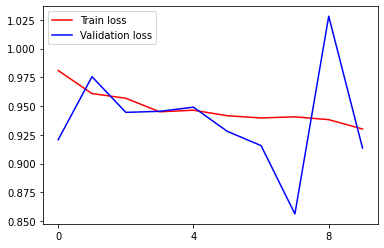

In [24]:
plt.plot(history.history['loss'], color='red', label='Train loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation loss')

plt.xticks(np.arange(number_of_epochs, step=4))
plt.legend()
plt.show()

### 2. Based on accuracy

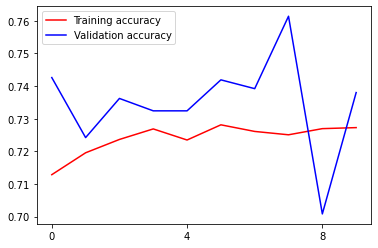

In [25]:
plt.plot(history.history['accuracy'], color='red', label='Training accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation accuracy')

plt.xticks(np.arange(number_of_epochs, step=4))
plt.legend()
plt.show()

## Evaluate with Confusion Matrix and Classification Report

### Generate actual and predicted value

In [18]:
y_true = np.concatenate([y for _, y in test_ds], axis=0)

Y_pred = model.predict(test_ds)
y_pred = np.argmax(Y_pred, axis=1)

2022-03-16 03:35:31.480331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Plot Confusion matrix

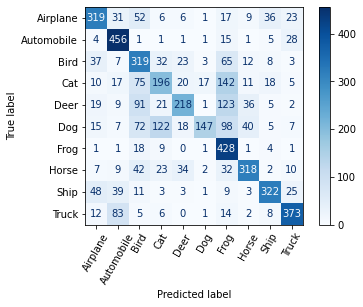

In [19]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                        display_labels=[class_name.capitalize() for class_name in class_names],
                                        cmap='Blues')

plt.xticks(rotation=60)
plt.savefig('../TrainingReport/confusion_matrix.pdf')
plt.show()

### Plot classification report

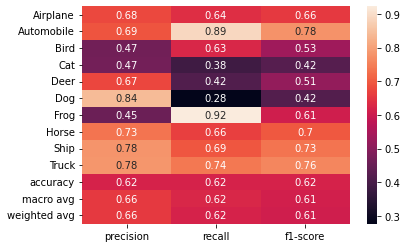

In [20]:
clf_rep = classification_report(y_true, y_pred, 
                                target_names=[class_name.capitalize() for class_name in class_names], 
                                output_dict=True)

sn.heatmap(pd.DataFrame(clf_rep).iloc[:-1,:].T, annot=True)
plt.savefig('../TrainingReport/report.pdf')